In [2]:
# pip install mlflow

  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached gitpython-3.1.45-py3-none-any.whl.metadata (13 kB)
  Using cached importlib_metadata-8.7.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached sqlparse-0.5.3-py3-none-any.whl.metadata (3.9 kB)
  Using cached cffi-1.17.1-cp313-cp313-win_amd64.whl.metadata (1.6 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached zipp-3.23.0-py3-none-any.whl.metadata (3.6 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached pycp

In [3]:
import numpy as np, os, json, mlflow, matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

import evaluate
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

c:\Users\jeremy.yap\OneDrive - Meinhardt Singapore Pte Ltd\NLP Classifier\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df_final = pd.read_parquet("data/final_data.parquet")
df_final

,project_title,client,project_type,project_title_and_client,label_id,labels
0,132027 - Moorabbin Hospital - Carpark Conver,AUVICKAN - Kane Construction Pty Ltd,Community And Institutional,132027 - Moorabbin Hospital - Carpark Conver A...,2,2
1,130348 - New Epping - Medical Building,AUVICRIVE - Riverlee Pty Ltd,Community And Institutional,130348 - New Epping - Medical Building AUVICRI...,2,2
2,130524 - RWH Rapid Access Hub,GRAY981 - GRAY PUKSAND PTY LTD,Community And Institutional,130524 - RWH Rapid Access Hub GRAY981 - GRAY P...,2,2
3,131450 - Monash Medical Centre Tower Exp,AUVICLYO - Lyons Architects,Community And Institutional,131450 - Monash Medical Centre Tower Exp AUVIC...,2,2
4,131568 - RWH Level 3 Birthing Suite,GRAY981 - GRAY PUKSAND PTY LTD,Community And Institutional,131568 - RWH Level 3 Birthing Suite GRAY981 - ...,2,2
...,...,...,...,...,...,...
16959,EKU Energy,Fortec,Industrial,EKU Energy Fortec,6,6
16960,STT (Peer review)_PO#1,STT,Industrial,STT (Peer review)_PO#1 STT,6,6
16961,Air Trunk (MEP),Air Trunk,Industrial,Air Trunk (MEP) Air Trunk,6,6
16962,VDC KIX12,Taisei Corporation,Industrial,VDC KIX12 Taisei Corporation,6,6


In [5]:
# ====== CONFIG ======
MODEL_NAME = "distilbert-base-uncased"      # try 'distilbert-base-multilingual-cased' if non-English
MAX_LENGTH = 64                              # titles are short; 64–128 is plenty
BATCH_SIZE = 16                              # raise if GPU has headroom
LR = 3e-5
EPOCHS = 3
SEED = 42
OUTPUT_DIR = "distilbert_projects"

In [6]:
# ====== 1) Load & clean ======

# Normalize labels (fix case variants like 'Commercial' vs 'commercial')
df_final["project_type"] = (
    df_final["project_type"]
    .astype(str)
    .str.strip()
    .replace({"nan": np.nan, "": np.nan})
    .str.replace("&", "and", regex=False)
    .str.title()   # 'community & institutional' -> 'Community And Institutional'
)

In [7]:
# ====== 2) Encode labels & stratified split ======
le = LabelEncoder()
df_final["labels"] = le.fit_transform(df_final["project_type"])
id2label = {i: l for i, l in enumerate(le.classes_)}
label2id = {l: i for i, l in id2label.items()}
num_labels = len(id2label)
print("Labels:", label2id)

X_train, X_val = train_test_split(
    df_final,
    test_size=0.3,
    random_state=SEED,
    stratify=df_final["labels"]
)


Labels: {'Aviation': 0, 'Commercial': 1, 'Community And Institutional': 2, 'Data Center': 3, 'Healthcare': 4, 'Hotel And Resort': 5, 'Industrial': 6, 'Infrastructure': 7, 'Mining And Resources': 8, 'Mixed Use Development': 9, 'Residential': 10, 'Water And Environment': 11}


In [8]:
# ====== 3) Build HF Dataset & tokenize ======
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def preprocess(batch):
    return tokenizer(
        batch["project_title_and_client"],
        truncation=True,
        max_length=MAX_LENGTH
    )

train_ds = Dataset.from_pandas(X_train[["project_title_and_client", "labels"]])
val_ds   = Dataset.from_pandas(X_val[["project_title_and_client", "labels"]])

train_ds = train_ds.map(preprocess, batched=True, remove_columns=["project_title_and_client"])
val_ds   = val_ds.map(preprocess,   batched=True, remove_columns=["project_title_and_client"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████| 5090/5090 [00:00<00:00, 48230.54 examples/s]


In [9]:
# ====== 4) Define model & Trainer ======

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"]
        # "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,                             # uses mixed precision if GPU+AMP available
    logging_steps=50,
    seed=SEED,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\jeremy.yap\AppData\Local\Temp\ipykernel_112080\2380742973.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


2025/09/02 15:28:56 INFO mlflow.tracking.fluent: Experiment with name 'project_title_classifier' does not exist. Creating a new experiment.
c:\Users\jeremy.yap\OneDrive - Meinhardt Singapore Pte Ltd\NLP Classifier\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy
200,1.322500,1.196585,0.650098
400,1.006700,0.932375,0.706090
600,0.778200,0.733315,0.781532
800,0.556800,0.657002,0.799804
1000,0.453800,0.619891,0.818075
1200,0.434800,0.536652,0.852652
1400,0.391300,0.474831,0.870138
1600,0.273700,0.422358,0.884283
1800,0.241200,0.420723,0.887623
2000,0.276600,0.400134,0.898232


c:\Users\jeremy.yap\OneDrive - Meinhardt Singapore Pte Ltd\NLP Classifier\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\jeremy.yap\OneDrive - Meinhardt Singapore Pte Ltd\NLP Classifier\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\jeremy.yap\OneDrive - Meinhardt Singapore Pte Ltd\NLP Classifier\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\jeremy.yap\OneDrive - Meinhardt Singapore Pte Ltd\NLP Classifier\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' 

c:\Users\jeremy.yap\OneDrive - Meinhardt Singapore Pte Ltd\NLP Classifier\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Device set to use cpu
2025/09/02 16:06:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\jeremy.yap\OneDrive - Meinhardt Singapore Pte Ltd\NLP Classifier\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jeremy.yap\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://

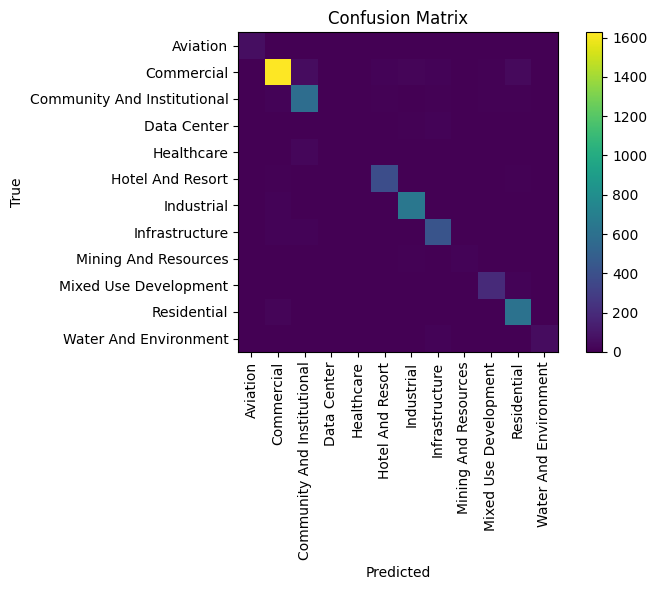

In [11]:
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("project_title_classifier")

with mlflow.start_run(run_name=f"{MODEL_NAME}-s{MAX_LENGTH}-b{BATCH_SIZE}"):
    # 1) params / label map
    mlflow.log_params({
        "model_name": MODEL_NAME, "max_length": MAX_LENGTH,
        "batch_size": BATCH_SIZE, "lr": LR, "epochs": EPOCHS,
        "seed": SEED, "num_labels": num_labels
    })
    os.makedirs("artifacts", exist_ok=True)
    with open("artifacts/id2label.json","w") as f: json.dump(id2label, f, indent=2)
    mlflow.log_artifact("artifacts/id2label.json", artifact_path="meta")

    # 2) training (Trainer still logs metrics because report_to=["mlflow"])
    trainer.train()

    # 3) final eval metrics
    eval_metrics = trainer.evaluate()
    mlflow.log_metrics({f"final_{k}": float(v) for k,v in eval_metrics.items()})

    # 4) confusion matrix + report
    pred_logits = trainer.predict(val_ds).predictions
    y_pred = pred_logits.argmax(axis=1)
    y_true = X_val["labels"].to_numpy()

    cm = confusion_matrix(y_true, y_pred, labels=range(num_labels))
    cm_df = pd.DataFrame(cm, index=[id2label[i] for i in range(num_labels)],
                            columns=[id2label[i] for i in range(num_labels)])
    cm_path_csv = "artifacts/confusion_matrix.csv"
    cm_df.to_csv(cm_path_csv)
    mlflow.log_artifact(cm_path_csv, artifact_path="eval")

    # quick heatmap without seaborn
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar()
    tick = np.arange(num_labels)
    plt.xticks(tick, [id2label[i] for i in range(num_labels)], rotation=90)
    plt.yticks(tick, [id2label[i] for i in range(num_labels)])
    plt.tight_layout()
    cm_path_png = "artifacts/confusion_matrix.png"
    plt.savefig(cm_path_png, dpi=150)
    mlflow.log_artifact(cm_path_png, artifact_path="eval")

    # classification report text
    report_txt = classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(num_labels)],
                                       zero_division=0)
    with open("artifacts/classification_report.txt","w") as f: f.write(report_txt)
    mlflow.log_artifact("artifacts/classification_report.txt", artifact_path="eval")

    # 5) save & log model artifacts
    trainer.save_model(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)
    mlflow.log_artifacts(OUTPUT_DIR, artifact_path="model")

    # (optional) log the HF pipeline as a single MLflow model, if available
    try:
        from transformers import pipeline
        import mlflow.transformers as mlhf
        clf = pipeline("text-classification", model=model, tokenizer=tokenizer, truncation=True)
        mlhf.log_model(clf, artifact_path="hf_pipeline",
                       input_example={"text": "Sample project title"},
                       registered_model_name="project_title_classifier")
    except Exception:
        pass


In [12]:
cm_df

,Aviation,Commercial,Community And Institutional,Data Center,Healthcare,Hotel And Resort,Industrial,Infrastructure,Mining And Resources,Mixed Use Development,Residential,Water And Environment
Aviation,58,4,0,0,0,0,0,3,0,0,0,0
Commercial,1,1627,53,0,0,13,22,16,0,11,39,1
Community And Institutional,1,17,582,0,0,7,2,9,0,11,10,0
Data Center,0,3,0,0,0,0,9,15,0,0,0,0
Healthcare,0,1,31,0,0,0,0,0,0,0,0,0
Hotel And Resort,0,10,5,0,0,384,2,2,0,0,7,1
Industrial,0,15,5,0,0,0,642,5,4,0,2,0
Infrastructure,1,17,19,0,0,5,4,423,1,1,6,6
Mining And Resources,0,0,0,0,0,0,11,0,13,0,0,2
Mixed Use Development,0,6,5,1,0,0,2,3,0,191,17,0


In [14]:
cm_df_2 = pd.DataFrame(cm, index=[f"true:{id2label[i]}" for i in range(num_labels)],
                            columns=[f"pred:{id2label[i]}" for i in range(num_labels)])

cm_df_2

,pred:Aviation,pred:Commercial,pred:Community And Institutional,pred:Data Center,pred:Healthcare,pred:Hotel And Resort,pred:Industrial,pred:Infrastructure,pred:Mining And Resources,pred:Mixed Use Development,pred:Residential,pred:Water And Environment
true:Aviation,58,4,0,0,0,0,0,3,0,0,0,0
true:Commercial,1,1627,53,0,0,13,22,16,0,11,39,1
true:Community And Institutional,1,17,582,0,0,7,2,9,0,11,10,0
true:Data Center,0,3,0,0,0,0,9,15,0,0,0,0
true:Healthcare,0,1,31,0,0,0,0,0,0,0,0,0
true:Hotel And Resort,0,10,5,0,0,384,2,2,0,0,7,1
true:Industrial,0,15,5,0,0,0,642,5,4,0,2,0
true:Infrastructure,1,17,19,0,0,5,4,423,1,1,6,6
true:Mining And Resources,0,0,0,0,0,0,11,0,13,0,0,2
true:Mixed Use Development,0,6,5,1,0,0,2,3,0,191,17,0
